# Model 1: LSTM

In [1]:
# Importing the necessary libraries
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [77]:
# Load the Apple stock price dataset
data_dir = 'AAPL_stock.csv'
df = pd.read_csv(data_dir)
print(df.head())


         Date      Open      High       Low     Close  Adj Close     Volume
0  1980-12-12  0.128348  0.128906  0.128348  0.128348   0.100178  469033600
1  1980-12-15  0.122210  0.122210  0.121652  0.121652   0.094952  175884800
2  1980-12-16  0.113281  0.113281  0.112723  0.112723   0.087983  105728000
3  1980-12-17  0.115513  0.116071  0.115513  0.115513   0.090160   86441600
4  1980-12-18  0.118862  0.119420  0.118862  0.118862   0.092774   73449600


In [78]:
# Get the dimensions of the DataFrame
print(df.shape)

# Get the column names of the DataFrame
print(df.columns)

(10443, 7)
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


## Data Pre-processing

In [79]:
# Display concise summary information about the DataFrame
print(df.info())
print(df.describe().T)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10443 entries, 0 to 10442
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10443 non-null  object 
 1   Open       10443 non-null  float64
 2   High       10443 non-null  float64
 3   Low        10443 non-null  float64
 4   Close      10443 non-null  float64
 5   Adj Close  10443 non-null  float64
 6   Volume     10443 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 571.2+ KB
None
             count          mean           std       min           25%  \
Open       10443.0  1.445356e+01  3.133780e+01  0.049665  2.834820e-01   
High       10443.0  1.461192e+01  3.169969e+01  0.049665  2.890630e-01   
Low        10443.0  1.429479e+01  3.097909e+01  0.049107  2.758930e-01   
Close      10443.0  1.445860e+01  3.135125e+01  0.049107  2.828905e-01   
Adj Close  10443.0  1.382399e+01  3.104663e+01  0.038329  2.352140e-01   
Volume     10443.0 

In [80]:
# Extracting date part from the 'Date' column and assigning it back to the 'Date' column
df['Date'] = pd.to_datetime(df['Date'])


In [81]:
# Grouping the DataFrame by date and calculating the mean of 'Open', 'Close', 'High', 'Low', and 'Volume' columns
df_day = df.groupby('Date')[['Open', 'High', 'Low', 'Close', 'Adj Close' ,'Volume',]].mean()

In [82]:
# Converting the grouped DataFrame to a new DataFrame
df_day = pd.DataFrame(df_day)

# Check for missing values in each column of the DataFrame
print(df_day.isna().sum())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [83]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100178,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094952,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087983,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090160,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092774,73449600
...,...,...,...,...,...,...,...
10438,2022-05-06,156.009995,159.440002,154.179993,157.279999,157.279999,116055700
10439,2022-05-09,154.929993,155.830002,151.490005,152.059998,152.059998,131577900
10440,2022-05-10,155.520004,156.740005,152.929993,154.509995,154.509995,115366700
10441,2022-05-11,153.500000,155.449997,145.809998,146.500000,146.500000,142689800


## Feature engineering

In [84]:
# Importing MinMaxScaler from sklearn.preprocessing module
from sklearn.preprocessing import MinMaxScaler

# Creating a MinMaxScaler object with feature range scaled between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))

# Reshaping the closing price values into a 2D array and scaling the data
scaled_data = scaler.fit_transform(np.array(df_day['Close']).reshape(-1, 1))

## Train test split

In [85]:
# Splitting the data into training and testing sets
train_size = int(len(scaled_data) * 0.75)
test_size = len(scaled_data) - train_size
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Creating a Training set with 60 time-steps and 1 output
x_train = []
y_train = []


In [86]:
for i in range(60, len(train_data)):
    x_train.append(train_data[i - 60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

# Reshaping the input
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

## building simple LSTM

In [87]:
# Define the LSTM model architecture
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    LSTM(64, return_sequences=False),
    Dense(32),
    Dense(16),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

In [88]:
# Fit the LSTM model to the training set
callbacks = [EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)]
history = model.fit(x_train, y_train, epochs=100, batch_size=32, callbacks=callbacks)

Epoch 1/100
243/243 [==============================] - 21s 64ms/step - loss: 1.4998e-05
Epoch 2/100
243/243 [==============================] - 16s 64ms/step - loss: 1.0466e-06
Epoch 3/100
243/243 [==============================] - 16s 66ms/step - loss: 1.1588e-06
Epoch 4/100
243/243 [==============================] - 15s 61ms/step - loss: 1.1695e-06
Epoch 5/100
243/243 [==============================] - 15s 62ms/step - loss: 1.0207e-06
Epoch 6/100
243/243 [==============================] - 15s 61ms/step - loss: 1.4155e-06
Epoch 7/100
243/243 [==============================] - 15s 61ms/step - loss: 1.0462e-06
Epoch 8/100
243/243 [==============================] - 17s 68ms/step - loss: 1.4254e-06
Epoch 9/100
243/243 [==============================] - 15s 61ms/step - loss: 1.1333e-06
Epoch 10/100
243/243 [==============================] - 17s 70ms/step - loss: 9.9311e-07
Epoch 11/100
243/243 [==============================] - 15s 63ms/step - loss: 6.3480e-07
Epoch 12/100
243/243 [========

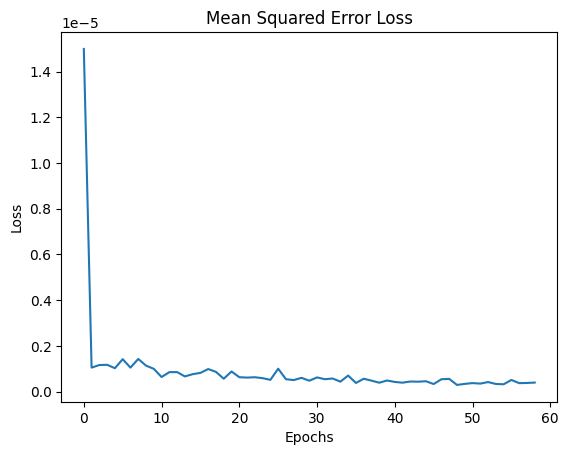

In [89]:
# Plotting the training losses over epochs
plt.plot(history.history["loss"])
plt.title("Mean Squared Error Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()


In [90]:
# Creating a testing set with 60 time-steps and 1 output
x_test = []
y_test = []

for i in range(60, len(test_data)):
    x_test.append(test_data[i - 60:i, 0])
    y_test.append(test_data[i, 0])

x_test, y_test = np.array(x_test), np.array(y_test)

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

## Evaluation metrics

In [91]:
# Perform predictions on the test data
predictions = model.predict(x_test)

# Inverse scaling to obtain actual values
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform([y_test])

# Calculate Mean Squared Error (MSE) and Root Mean Squared Error (RMSE)
mse = mean_squared_error(y_test[0], predictions[:, 0])
rmse = math.sqrt(mse)
print("LSTM model: ")
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)


80/80 [==============================] - 2s 18ms/step
LSTM model: 
Mean Squared Error (MSE): 5.519961150127764
Root Mean Squared Error (RMSE): 2.349459757077734


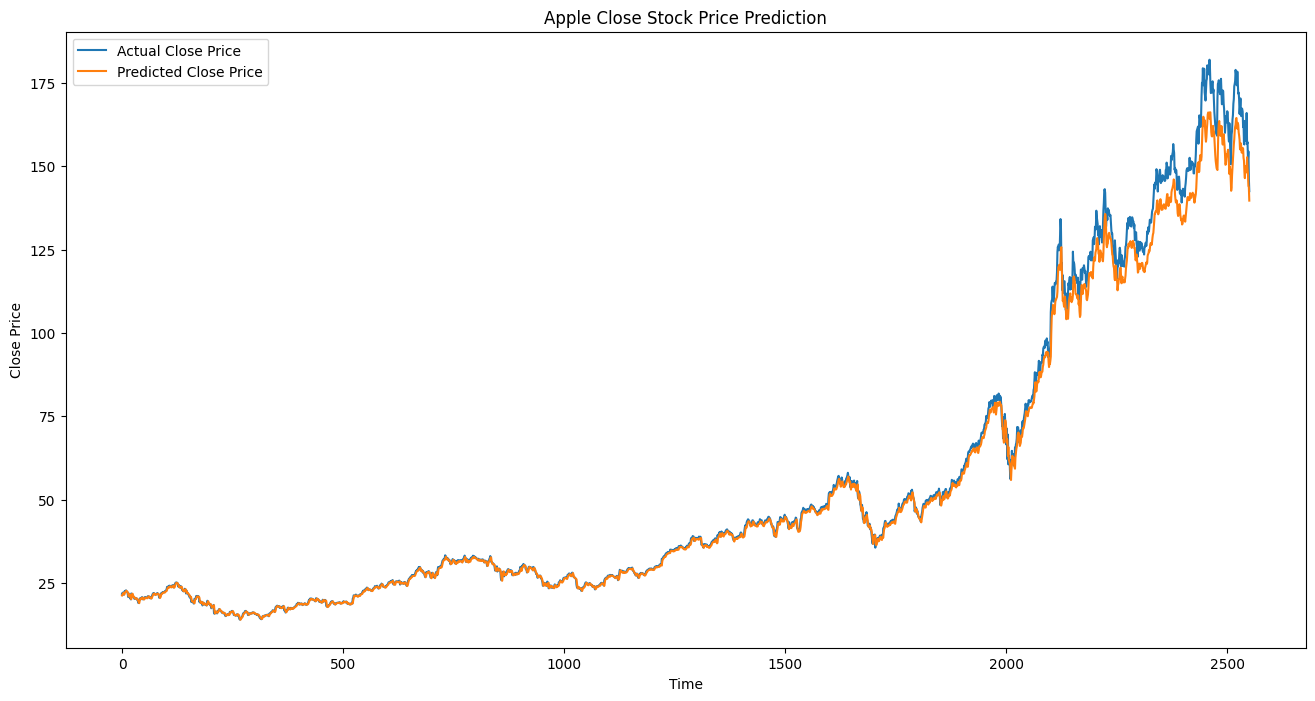

In [17]:
# Plotting the predicted and actual closing prices
plt.figure(figsize=(16, 8))
plt.plot(y_test[0], label='Actual Close Price')
plt.plot(predictions[:, 0], label='Predicted Close Price')
plt.title('Apple Close Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Model 2 : Complex LSTM

In [18]:
# Importing libraries for the analysis
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error


In [19]:
# Importing the dataset
dataset_train = pd.read_csv('AAPL_stock.csv')

# Preprocessing the data
training_set = dataset_train[['Close']].values
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [20]:

# Creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(60, len(training_set)):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [21]:
# Building the LSTM model
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [22]:
# Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Fitting the model to the training set
model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
325/325 [==============================] - 64s 166ms/step - loss: 0.0012
Epoch 2/100
325/325 [==============================] - 44s 136ms/step - loss: 6.4305e-04
Epoch 3/100
325/325 [==============================] - 40s 123ms/step - loss: 5.3424e-04
Epoch 4/100
325/325 [==============================] - 40s 124ms/step - loss: 5.2359e-04
Epoch 5/100
325/325 [==============================] - 40s 122ms/step - loss: 5.7059e-04
Epoch 6/100
325/325 [==============================] - 39s 120ms/step - loss: 4.4471e-04
Epoch 7/100
325/325 [==============================] - 39s 121ms/step - loss: 4.2637e-04
Epoch 8/100
325/325 [==============================] - 40s 123ms/step - loss: 4.7685e-04
Epoch 9/100
325/325 [==============================] - 42s 128ms/step - loss: 4.6609e-04
Epoch 10/100
325/325 [==============================] - 40s 122ms/step - loss: 3.9038e-04
Epoch 11/100
325/325 [==============================] - 40s 123ms/step - loss: 3.8209e-04
Epoch 12/100
325/325 [=

In [23]:
# Getting the real stock price of 2020
dataset_test = pd.read_csv('AAPL_stock.csv')
real_stock_price = dataset_test[['Close']].values

# Getting the predicted stock price of 2020
dataset_total = pd.concat((dataset_train['Close'], dataset_test['Close']), axis=0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

In [24]:
X_test = []
for i in range(60, len(dataset_test) + 60):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

327/327 [==============================] - 13s 34ms/step


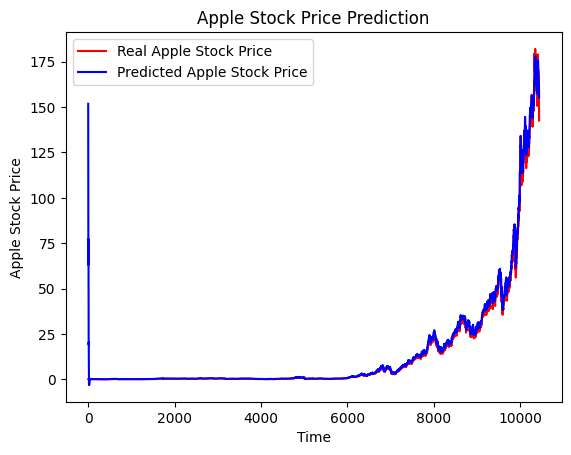

In [25]:
# Visualizing the results
plt.plot(real_stock_price, color='red', label='Real Apple Stock Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted Apple Stock Price')
plt.title('Apple Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.show()

## eavlution metrics

In [76]:
# Evaluating the model
mse = mean_squared_error(real_stock_price, predicted_stock_price)
rmse = np.sqrt(mse)

print("Complex LSTM model: ")
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)


Complex LSTM model: 
Mean Squared Error (MSE): 10.103565526469401
Root Mean Squared Error (RMSE): 3.1786106283200843


# Model 3: Machine learning model

In [28]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

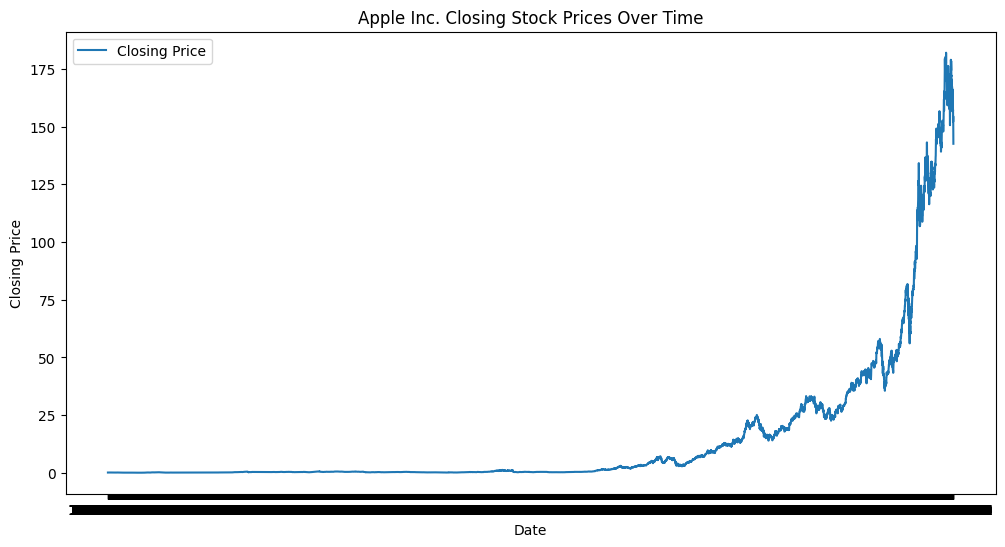

In [70]:

# Load the dataset (historical stock prices of Apple Inc.)
data = pd.read_csv('AAPL_stock.csv')

# Visualize the closing prices over time
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], data['Close'], label='Closing Price')
plt.title('Apple Inc. Closing Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

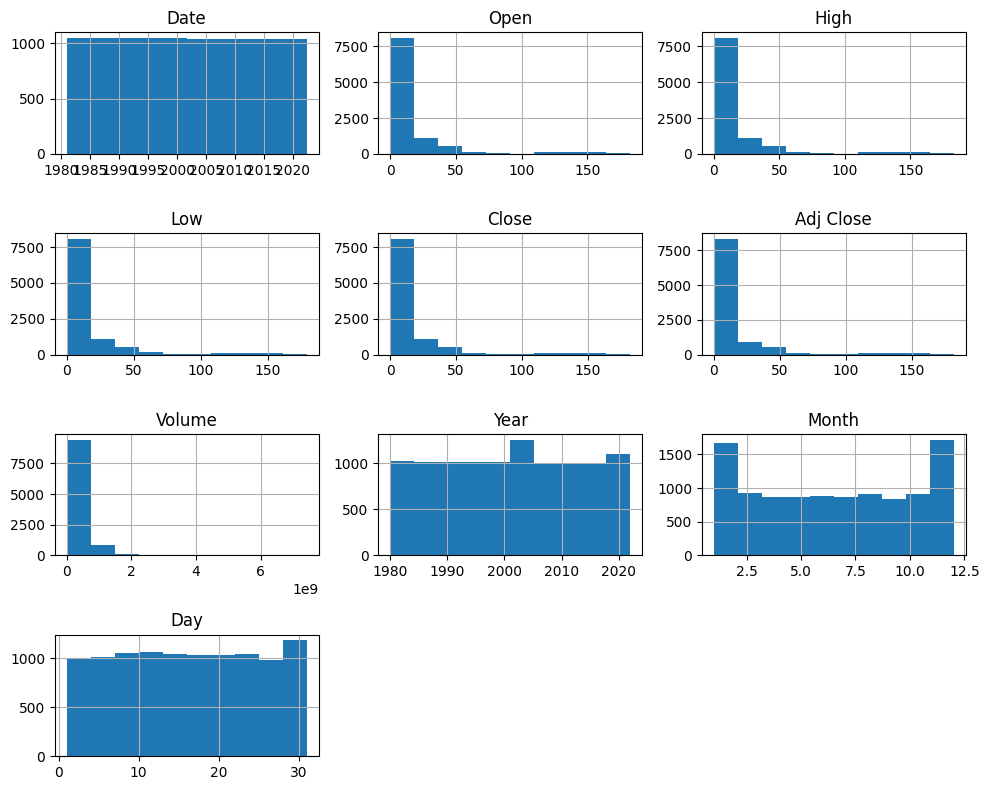

In [66]:
# Histograms
data.hist(figsize=(10, 8))
plt.tight_layout()
plt.show()

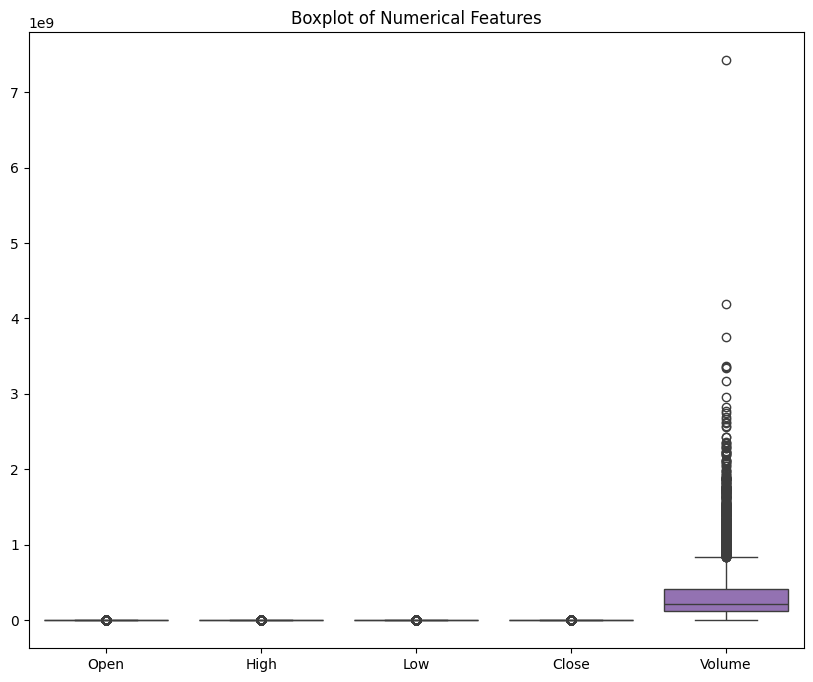

In [67]:
# Box plots
plt.figure(figsize=(10, 8))
sns.boxplot(data=data[['Open', 'High', 'Low', 'Close', 'Volume']])
plt.title('Boxplot of Numerical Features')
plt.show()


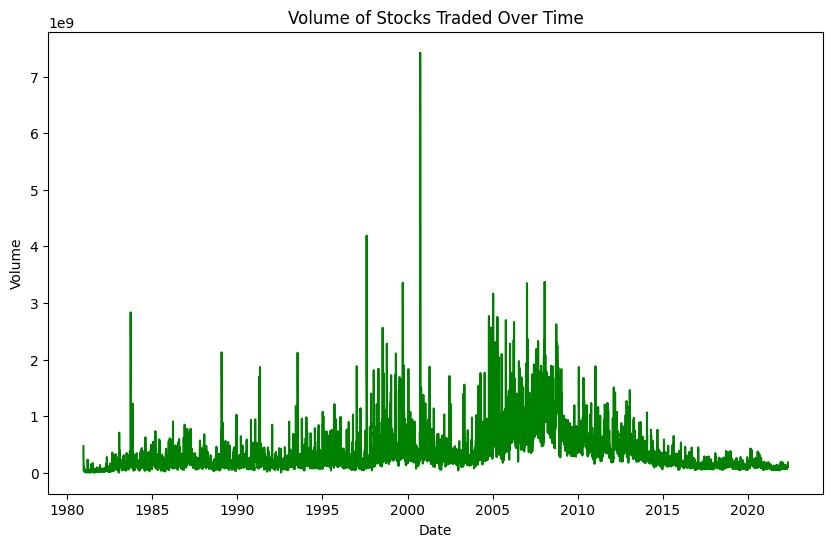

In [68]:
#Analyze the volume of stocks traded over time to identify any significant trends or patterns.
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['Volume'], color='green')
plt.title('Volume of Stocks Traded Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

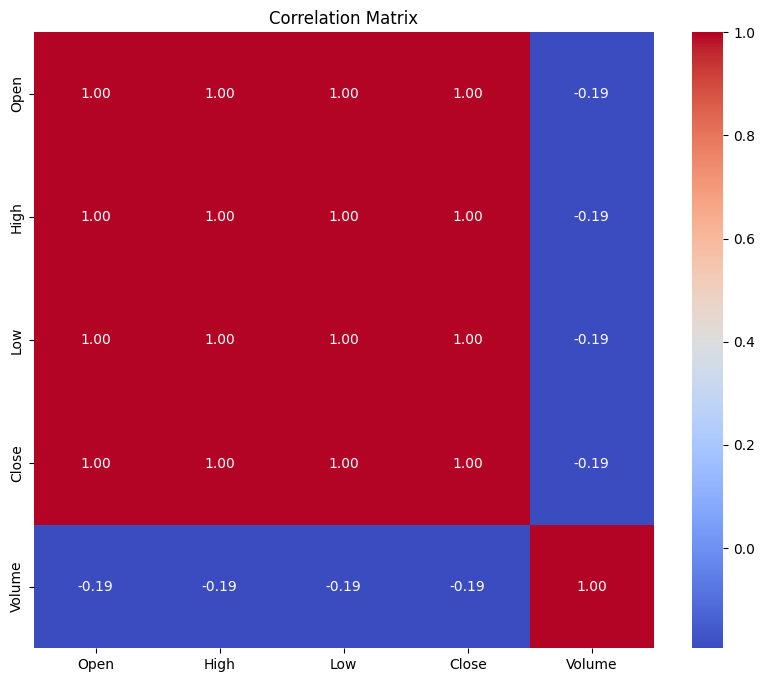

In [69]:
#Compute the correlation matrix between numerical features.
correlation_matrix = data[['Open', 'High', 'Low', 'Close', 'Volume']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [65]:
data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Year',
       'Month', 'Day'],
      dtype='object')

In [30]:
# Data preprocessing
# Convert 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Feature engineering: extracting additional date-related features
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day

In [31]:
# Scaling the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Year', 'Month', 'Day']])

# Convert scaled data back to DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Year', 'Month', 'Day'])

# Define features (X) and target variable (y)
X = scaled_df.drop('Close', axis=1)
y = scaled_df['Close']

In [32]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## ML models

In [33]:
# Machine Learning Models
# Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Support Vector Machine (SVM) model
svm_model = SVR(kernel='linear')
svm_model.fit(X_train, y_train)

# Predictions
rf_predictions = rf_model.predict(X_test)
svm_predictions = svm_model.predict(X_test)

# Evaluation
rf_mse = mean_squared_error(y_test, rf_predictions)
svm_mse = mean_squared_error(y_test, svm_predictions)

rf_rmse = np.sqrt(rf_mse)
svm_rmse = np.sqrt(svm_mse)


In [34]:
print("Random Forest Model:")
print("MSE:", rf_mse)
print("RMSE:", rf_rmse)

print("\nSupport Vector Machine (SVM) Model:")
print("MSE:", svm_mse)
print("RMSE:", svm_rmse)

Random Forest Model:
MSE: 6.933556562798694e-07
RMSE: 0.0008326798041743713

Support Vector Machine (SVM) Model:
MSE: 0.006480924504849589
RMSE: 0.08050418936210456


## R2 score for variance calculation

In [35]:
from sklearn.metrics import r2_score

# Calculate R-squared for Random Forest model
rf_r2_train = r2_score(y_train, rf_model.predict(X_train))
rf_r2_test = r2_score(y_test, rf_predictions)

print("Random Forest Model:")
print("R-squared (Training):", rf_r2_train)
print("R-squared (Testing):", rf_r2_test)

# Calculate R-squared for SVM model
svm_r2_train = r2_score(y_train, svm_model.predict(X_train))
svm_r2_test = r2_score(y_test, svm_predictions)

print("\nSupport Vector Machine (SVM) Model:")
print("R-squared (Training):", svm_r2_train)
print("R-squared (Testing):", svm_r2_test)

Random Forest Model:
R-squared (Training): 0.9999976776709547
R-squared (Testing): 0.999978647123815

Support Vector Machine (SVM) Model:
R-squared (Training): 0.7768422027162727
R-squared (Testing): 0.8004106878443288


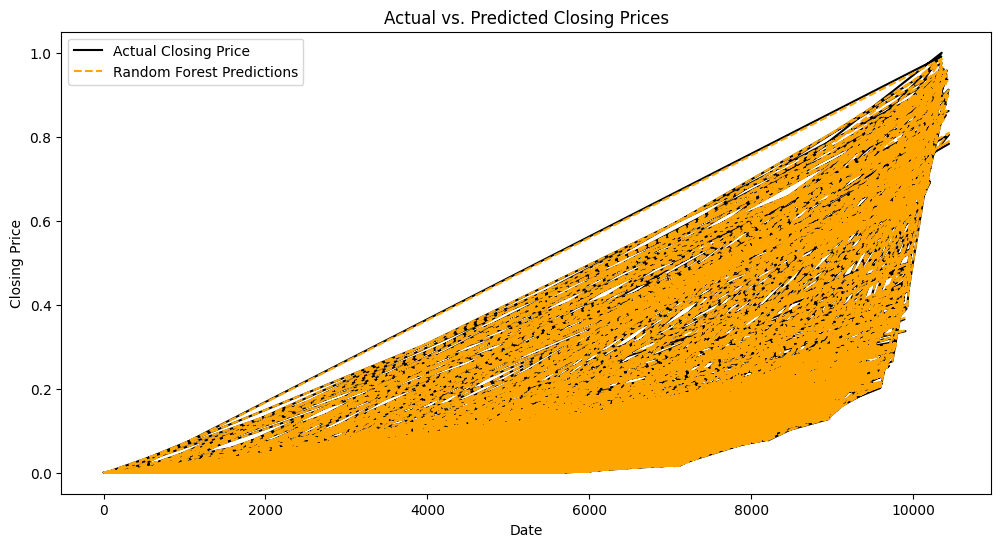

In [42]:
# Visualize actual vs. predicted closing prices
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label='Actual Closing Price', color='black')
plt.plot(y_test.index, rf_predictions, label='Random Forest Predictions', linestyle='--', color='orange')
plt.title('Actual vs. Predicted Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

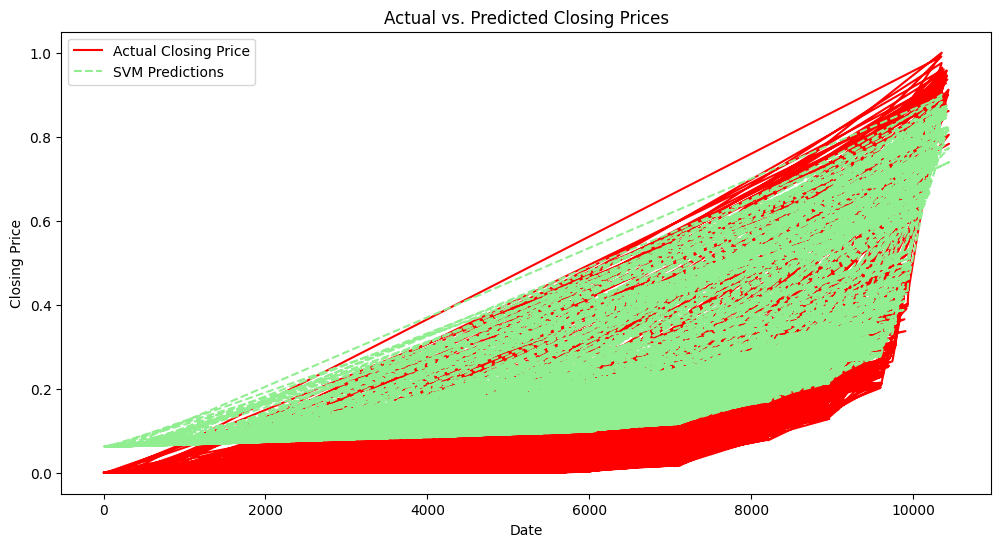

In [43]:
# Visualize actual vs. predicted closing prices
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label='Actual Closing Price', color='red')
plt.plot(y_test.index, svm_predictions, label='SVM Predictions', linestyle='--', color='lightgreen')
plt.title('Actual vs. Predicted Closing Prices')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

# Model 3b - Other ML models

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [51]:

# Load the dataset
data_2 = pd.read_csv("AAPL_stock.csv")

# Preprocessing
# Convert 'DATE' column to datetime format
data_2['Date'] = pd.to_datetime(data_2['Date'])
# Set 'DATE' column as index
data_2.set_index('Date', inplace=True)
# Drop irrelevant columns
data_2.drop(['Adj Close'], axis=1, inplace=True)

# Feature engineering
data_2['MOV_AVG_7'] = data_2['Close'].rolling(window=7).mean()
data_2['MOV_AVG_30'] = data_2['Close'].rolling(window=30).mean()

# Drop rows with NaN values due to rolling averages
data_2.dropna(inplace=True)

# Define features and target variable
X = data_2.drop('Close', axis=1)
y = data_2['Close']

In [52]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## other ml models - ridge regression & decision tree

In [53]:
# Machine Learning Models
# Ridge Regression
ridge = Ridge()
ridge.fit(X_train_scaled, y_train)
ridge_predictions = ridge.predict(X_test_scaled)
ridge_mse = mean_squared_error(y_test, ridge_predictions)
ridge_rmse = np.sqrt(ridge_mse)
ridge_r2 = r2_score(y_test, ridge_predictions)

# Decision Tree
dtree = DecisionTreeRegressor()
dtree.fit(X_train_scaled, y_train)
dtree_predictions = dtree.predict(X_test_scaled)
dtree_mse = mean_squared_error(y_test, dtree_predictions)
dtree_rmse = np.sqrt(dtree_mse)
dtree_r2 = r2_score(y_test, dtree_predictions)

In [62]:
# Evaluation
print("Machine Learning Models: \n")
print("Ridge Regression -")
print(" MSE:", ridge_mse,"\n", "RMSE:", ridge_rmse,"\n","R2 Score:", ridge_r2,"\n")
print("Decision Tree - ")
print(" MSE: ",dtree_mse,"\n", "RMSE:", dtree_rmse,"\n", "R2 Score:", dtree_r2)

Machine Learning Models: 

Ridge Regression -
 MSE: 0.3227141469779644 
 RMSE: 0.5680793491916111 
 R2 Score: 0.9997099812299765 

Decision Tree - 
 MSE:  0.3335520177937059 
 RMSE: 0.5775396244360259 
 R2 Score: 0.9997002413843791


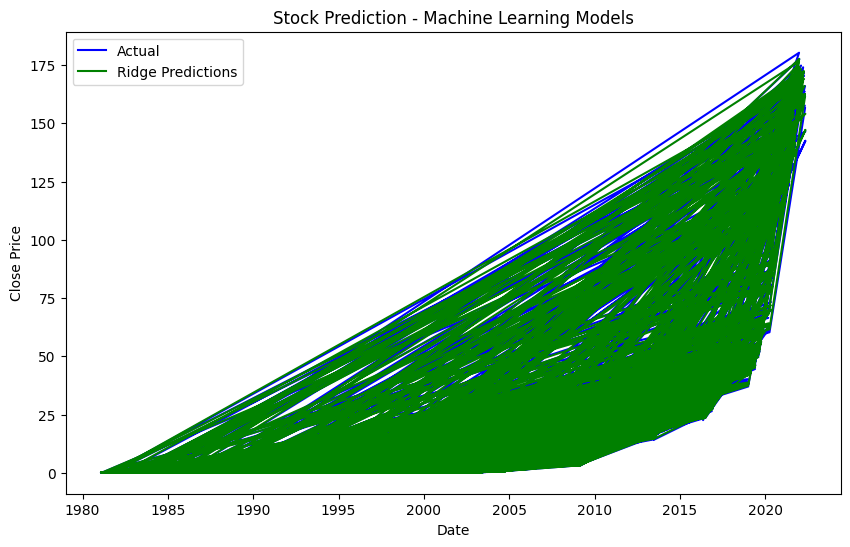

In [63]:

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test.values, label='Actual', color='blue')
plt.plot(y_test.index, ridge_predictions, label='Ridge Predictions', color='green')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Stock Prediction - Machine Learning Models')
plt.legend()
plt.show()

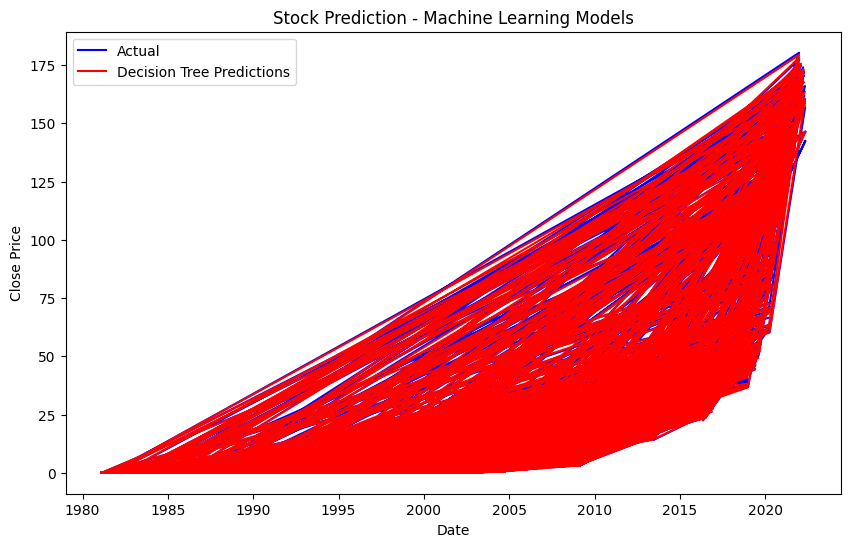

In [64]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test.values, label='Actual', color='blue')
plt.plot(y_test.index, dtree_predictions, label='Decision Tree Predictions', color='red')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Stock Prediction - Machine Learning Models')
plt.legend()
plt.show()

# Model 4 - Sequential DL

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error, r2_score

In [45]:
# Load the dataset
data_new = pd.read_csv("AAPL_stock.csv")

# Preprocessing
# Convert 'DATE' column to datetime format
data_new['Date'] = pd.to_datetime(data_new['Date'])
# Set 'DATE' column as index
data_new.set_index('Date', inplace=True)
# Drop irrelevant columns
data_new.drop(['Adj Close'], axis=1, inplace=True)

# Feature engineering
data_new['MOV_AVG_7'] = data_new['Close'].rolling(window=7).mean()
data_new['MOV_AVG_30'] = data_new['Close'].rolling(window=30).mean()

# Drop rows with NaN values due to rolling averages
data_new.dropna(inplace=True)

# Define features and target variable
X = data_new.drop('Close', axis=1)
y = data_new['Close']

In [46]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [47]:
# Deep Learning Models
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, verbose=0)

In [48]:
# Predictions
dl_predictions = model.predict(X_test_scaled).reshape(-1)
dl_mse = mean_squared_error(y_test, dl_predictions)
dl_rmse = np.sqrt(dl_mse)
dl_r2 = r2_score(y_test, dl_predictions)

# Evaluation
print("Deep Learning Model:")
print("MSE:", dl_mse, "RMSE:", dl_rmse, "R2 Score:", dl_r2)


66/66 [==============================] - 0s 3ms/step
Deep Learning Model:
MSE: 0.21806762951313283 RMSE: 0.4669771188325321 R2 Score: 0.9998040256174525


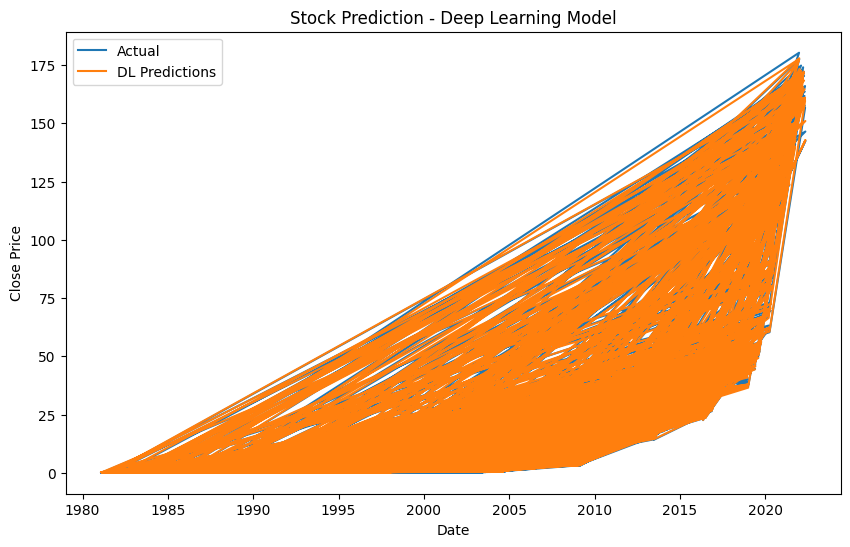

In [49]:
# Visualization
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, dl_predictions, label='DL Predictions')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Stock Prediction - Deep Learning Model')
plt.legend()
plt.show()